# Initialization

In [3]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

# Загрузка данных

In [5]:
items = pd.read_parquet("items.parquet")
events = pd.read_parquet("events.parquet")

# Разбиение с учётом хронологии

Рекомендательные системы на практике работают с учётом хронологии. Поэтому поток событий для тренировки и валидации полезно делить на то, что уже случилось, и что ещё случится. Это позволяет проводить валидацию на тех же пользователях, на которых тренировались, но на их событиях в будущем.

# === Знакомство: "холодный" старт

In [7]:
# Зададим точку разбиения
train_test_global_time_split_date = pd.to_datetime("2017-08-01").date()

# Разбиваем данные по дате
train_test_global_time_split_idx = events["started_at"] < train_test_global_time_split_date
events_train = events[train_test_global_time_split_idx].copy()
events_test = events[~train_test_global_time_split_idx].copy()

# Получаем уникальных пользователей в каждой выборке
users_train = events_train["user_id"].drop_duplicates()
users_test = events_test["user_id"].drop_duplicates()

# Находим пользователей, присутствующих в обеих выборках
common_users = set(users_train) & set(users_test)

print(len(users_train), len(users_test), len(common_users))

428220 123223 120858


In [8]:
# Уникальные пользователи в train и test
users_train = events_train["user_id"].unique()
users_test = events_test["user_id"].unique()

# Находим пересечение (общих пользователей)
common_users = set(users_train) & set(users_test)
num_common_users = len(common_users)

print(f"Количество общих пользователей: {num_common_users}")

Количество общих пользователей: 120858


«Холодные» пользователи — те, которые есть в test, но отсутствуют в train. Это соответствует хронологическому порядку, в котором и работает рекомендательная система.

In [9]:
# Уникальные пользователи в train и test
users_train = set(events_train["user_id"].unique())
users_test = set(events_test["user_id"].unique())

# Холодные пользователи (есть в test, но нет в train)
cold_users = users_test - users_train

print(f"Количество холодных пользователей: {len(cold_users)}")

Количество холодных пользователей: 2365


In [10]:
from sklearn.preprocessing import MinMaxScaler

# Фильтруем события с 2015 года
top_pop_start_date = pd.to_datetime("2015-01-01").date()

# Считаем популярность (уникальные пользователи) и средний рейтинг для каждой книги
item_popularity = events_train \
    .query("started_at >= @top_pop_start_date") \
    .groupby(["item_id"]).agg(
        users=("user_id", "nunique"), 
        avg_rating=("rating", "mean")
    ).reset_index()

# Нормализуем показатели (приводим к диапазону [0, 1])
scaler = MinMaxScaler()
item_popularity[["users_norm", "avg_rating_norm"]] = scaler.fit_transform(
    item_popularity[["users", "avg_rating"]]
)

# Вычисляем итоговый скор (произведение нормализованных значений)
item_popularity["popularity_score"] = (
    item_popularity["users_norm"] * item_popularity["avg_rating_norm"]
)

# Сортируем по убыванию popularity_score
item_popularity = item_popularity.sort_values("popularity_score", ascending=False)

# Выбираем топ-100 книг со средним рейтингом >= 4
top_k_pop_items = item_popularity[
    item_popularity["avg_rating"] >= 4
].head(100)

# Проверяем результат
print(f"Топ-100 популярных книг с 2015 года (avg_rating >= 4):")
print(top_k_pop_items[["item_id", "users", "avg_rating", "popularity_score"]].head())

Топ-100 популярных книг с 2015 года (avg_rating >= 4):
        item_id  users  avg_rating  popularity_score
32387  18007564  20207    4.321275          0.412333
32623  18143977  19462    4.290669          0.393471
2             3  15139    4.706057          0.344702
30695  16096824  16770    4.301014          0.340108
1916      15881  13043    4.632447          0.291076


### default recommendations

In [11]:
# добавляем информацию о книгах
top_k_pop_items = top_k_pop_items.merge(
    items.set_index("item_id")[["author", "title", "genre_and_votes", "publication_year"]], on="item_id")

with pd.option_context('display.max_rows', 100):
    display(top_k_pop_items[["item_id", "author", "title", "publication_year", "users", "avg_rating", "popularity_score", "genre_and_votes"]])

,item_id,author,title,publication_year,users,avg_rating,popularity_score,genre_and_votes
0,18007564,Andy Weir,The Martian,2014,20207,4.321275,0.412333,"{'Science Fiction': 11966, 'Fiction': 8430}"
1,18143977,Anthony Doerr,All the Light We Cannot See,2014,19462,4.290669,0.393471,"{'Historical-Historical Fiction': 13679, 'Fict..."
2,3,"J.K. Rowling, Mary GrandPré",Harry Potter and the Sorcerer's Stone (Harry P...,1997,15139,4.706057,0.344702,"{'Fantasy': 59818, 'Fiction': 17918, 'Young Ad..."
3,16096824,Sarah J. Maas,A Court of Thorns and Roses (A Court of Thorns...,2015,16770,4.301014,0.340108,"{'Fantasy': 14326, 'Young Adult': 4662, 'Roman..."
4,15881,"J.K. Rowling, Mary GrandPré",Harry Potter and the Chamber of Secrets (Harry...,1999,13043,4.632447,0.291076,"{'Fantasy': 50130, 'Young Adult': 15202, 'Fict..."
5,38447,Margaret Atwood,The Handmaid's Tale,1998,14611,4.232770,0.290194,"{'Fiction': 15424, 'Classics': 9937, 'Science ..."
6,11235712,Marissa Meyer,"Cinder (The Lunar Chronicles, #1)",2012,14348,4.179189,0.280247,"{'Young Adult': 10539, 'Fantasy': 9237, 'Scien..."
7,17927395,Sarah J. Maas,A Court of Mist and Fury (A Court of Thorns an...,2016,12177,4.730640,0.279094,"{'Fantasy': 10186, 'Romance': 3346, 'Young Adu..."
8,5,"J.K. Rowling, Mary GrandPré",Harry Potter and the Prisoner of Azkaban (Harr...,2004,11890,4.770143,0.275401,"{'Fantasy': 49784, 'Young Adult': 15393, 'Fict..."
9,13206900,Marissa Meyer,"Winter (The Lunar Chronicles, #4)",2015,12291,4.534293,0.266881,"{'Fantasy': 4835, 'Young Adult': 4672, 'Scienc..."


In [12]:
# Объединяем тестовые события холодных пользователей с рейтингами из топ-100
cold_users_events_with_recs = (
    events_test[events_test["user_id"].isin(cold_users)]
    .merge(
        top_k_pop_items[["item_id", "avg_rating"]],  # Берем только нужные столбцы
        on="item_id",
        how="left"
    )
)

# Находим события, для которых нет avg_rating (книга не в топ-100)
cold_user_items_no_avg_rating_idx = cold_users_events_with_recs["avg_rating"].isnull()

# Отбираем только события с известным avg_rating (книги из топ-100)
cold_user_recs = cold_users_events_with_recs[~cold_user_items_no_avg_rating_idx][
    ["user_id", "item_id", "rating", "avg_rating"]
]

In [13]:
print(f"Всего событий холодных пользователей: {len(cold_users_events_with_recs)}")
print(f"Событий с книгами из топ-100: {len(cold_user_recs)}")
print(f"Пример записей:\n{cold_user_recs.head(10)}")

Всего событий холодных пользователей: 9672
Событий с книгами из топ-100: 1912
Пример записей:
    user_id   item_id  rating  avg_rating
2   1361610  25899336       4    4.427261
5   1338996  16096824       5    4.301014
8   1338996  18692431       5    4.071454
9   1338996  28763485       2    4.194663
15  1276025     38447       5    4.232770
45  1027534     38447       5    4.232770
52  1408652  23437156       5    4.512300
56  1192858  20613470       4    4.495608
57  1192858  28260587       5    4.557174
58  1192858  18006496       5    4.610097


In [14]:
# Общее количество событий холодных пользователей
total_cold_events = len(cold_users_events_with_recs)

# Количество событий с книгами из топ-100 (где avg_rating не NaN)
matched_events = len(cold_user_recs)

# Вычисляем долю и округляем до сотых
match_ratio = round(matched_events / total_cold_events, 2)

print(f"Доля совпадений: {match_ratio}")

Доля совпадений: 0.2


In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Вычисляем RMSE (Root Mean Squared Error)
rmse = mean_squared_error(
    cold_user_recs["rating"], 
    cold_user_recs["avg_rating"], 
    squared=False  # Возвращаем квадратный корень
)

# Вычисляем MAE (Mean Absolute Error)
mae = mean_absolute_error(
    cold_user_recs["rating"], 
    cold_user_recs["avg_rating"]
)

# Выводим результаты с округлением
print(f"RMSE: {round(rmse, 2)}, MAE: {round(mae, 2)}")

RMSE: 0.78, MAE: 0.62


In [16]:
# посчитаем покрытие холодных пользователей рекомендациями

cold_users_hit_ratio = cold_users_events_with_recs.groupby("user_id").agg(hits=("avg_rating", lambda x: (~x.isnull()).mean()))

print(f"Доля пользователей без релевантных рекомендаций: {(cold_users_hit_ratio == 0).mean().iat[0]:.2f}")
print(f"Среднее покрытие пользователей: {cold_users_hit_ratio[cold_users_hit_ratio != 0].mean().iat[0]:.2f}")

Доля пользователей без релевантных рекомендаций: 0.59
Среднее покрытие пользователей: 0.44


# === Знакомство: первые персональные рекомендации

In [17]:
# Уникальные пользователи и предметы
n_users = events['user_id'].nunique()
n_items = events['item_id'].nunique()
total_cells = n_users * n_items

# Уникальные взаимодействия (пары user-item)
filled_cells = len(events[['user_id', 'item_id']].drop_duplicates())

# Степень разреженности
sparsity = 1 - (filled_cells / total_cells)

print(f"Разреженность U-I матрицы: {sparsity:.2%}")

Разреженность U-I матрицы: 99.93%


In [18]:
print(f"Всего пользователей: {n_users}")
print(f"Всего предметов: {n_items}")
print(f"Теоретически возможных взаимодействий: {total_cells:,}")
print(f"Фактических взаимодействий: {filled_cells:,}")

Всего пользователей: 430585
Всего предметов: 41673
Теоретически возможных взаимодействий: 17,943,768,705
Фактических взаимодействий: 11,751,086


In [19]:
from surprise import Dataset, Reader
from surprise import SVD

# используем Reader из библиотеки surprise для преобразования событий (events)
# в формат, необходимый surprise
reader = Reader(rating_scale=(1, 5))
surprise_train_set = Dataset.load_from_df(events_train[['user_id', 'item_id', 'rating']], reader)
surprise_train_set = surprise_train_set.build_full_trainset()

# инициализируем модель
svd_model = SVD(n_factors=100, random_state=0)

# обучаем модель
svd_model.fit(surprise_train_set)

In [20]:
surprise_test_set = list(events_test[['user_id', 'item_id', 'rating']].itertuples(index=False))

# получаем рекомендации для тестовой выборки
svd_predictions = svd_model.test(surprise_test_set)

In [21]:
from surprise import accuracy

rmse = accuracy.rmse(svd_predictions)
mae = accuracy.mae(svd_predictions)
                     
print(rmse, mae)

RMSE: 0.8289
MAE:  0.6474
0.8288711689059136 0.647437483750257


In [22]:
from surprise import NormalPredictor

# инициализируем состояние генератора, это необходимо для получения
# одной и той же последовательности случайных чисел, только в учебных целях
np.random.seed(0)

random_model = NormalPredictor()

random_model.fit(surprise_train_set)
random_predictions = random_model.test(surprise_test_set)

In [23]:
random_mae = accuracy.mae(random_predictions)

MAE:  1.0018


In [24]:
# Вычисляем на сколько процентов случайная модель хуже
percent_worse = ((random_mae - mae) / mae) * 100

print(f"MAE (SVD): {mae:.2f}")
print(f"MAE (Random): {random_mae:.2f}")
print(f"Случайные рекомендации хуже на: {round(percent_worse)}%")

MAE (SVD): 0.65
MAE (Random): 1.00
Случайные рекомендации хуже на: 55%


Факультативное задание
Задание. Удалите из events события для редких айтемов — таких, с которыми взаимодействовало менее N пользователей. Возьмите небольшое N, например 2–3 пользователя. Получите рекомендации, посчитайте метрики, оцените, как они изменились. Подумайте, с чем могут быть связаны такие изменения.

In [25]:
def get_recommendations_svd(user_id, all_items, events, model, include_seen=True, n=5):
    """Возвращает n рекомендаций для user_id
    
    Параметры:
    ----------
    user_id : str/int
        Идентификатор пользователя
    all_items : set/list
        Все возможные item_id в системе
    events : pd.DataFrame
        DataFrame с историей взаимодействий
    model : surprise.prediction_algorithms
        Обученная модель рекомендаций
    include_seen : bool, optional
        Включать ли уже просмотренные товары (по умолчанию True)
    n : int, optional
        Количество рекомендаций (по умолчанию 5)
    
    Возвращает:
    -----------
    pd.DataFrame
        DataFrame с колонками item_id и score, отсортированный по убыванию score
    """
    
    # Получаем список всех уникальных книг
    all_items = set(events['item_id'].unique())
    
    # Обрабатываем флаг include_seen
    if include_seen:
        items_to_predict = list(all_items)
    else:
        # Получаем книги, которые пользователь уже видел
        seen_items = set(events[events['user_id'] == user_id]['item_id'].unique())
        # Оставляем только новые книги
        items_to_predict = list(all_items - seen_items)
    
    # Получаем предсказания для всех рассматриваемых книг
    predictions = [model.predict(user_id, item_id) for item_id in items_to_predict]
    
    # Сортируем по убыванию оценки и берем топ-N
    recommendations = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]
    
    # Возвращаем DataFrame с рекомендациями
    return pd.DataFrame([(pred.iid, pred.est) for pred in recommendations], 
                       columns=["item_id", "score"])

In [26]:
get_recommendations_svd(1296647, items, events_test, svd_model)


,item_id,score
0,7864312,4.981188
1,25793186,4.912001
2,12174312,4.898052
3,13208,4.894869
4,33353628,4.891661


In [27]:
# выберем произвольного пользователя из тренировочной выборки ("прошлого")
user_id = events_train['user_id'].sample().iat[0]

print(f"user_id: {user_id}")

print("История (последние события, recent)")
user_history = (
    events_train
    .query("user_id == @user_id")
    .merge(items.set_index("item_id")[["author", "title", "genre_and_votes"]], on="item_id")
)
user_history_to_print = user_history[["author", "title", "started_at", "read_at", "rating", "genre_and_votes"]].tail(10)
display(user_history_to_print)

print("Рекомендации")
user_recommendations = get_recommendations_svd(user_id, items, events_train, svd_model)
user_recommendations = user_recommendations.merge(items[["item_id", "author", "title", "genre_and_votes"]], on="item_id")
display(user_recommendations) 

user_id: 1169023
История (последние события, recent)


,author,title,started_at,read_at,rating,genre_and_votes
68,Veronica Roth,"Divergent (Divergent, #1)",2014-06-02,2014-06-04,4,"{'Young Adult': 20260, 'Science Fiction-Dystop..."
69,"Gillian Flynn, В. Русанов",Gone Girl,2014-05-27,2014-05-29,5,"{'Fiction': 11773, 'Mystery': 9965, 'Thriller'..."
70,Kathy Reichs,"Death du Jour (Temperance Brennan, #2)",2014-05-24,2014-05-27,4,"{'Mystery': 1206, 'Mystery-Crime': 579, 'Ficti..."
71,Chelsea Cain,"Heartsick (Archie Sheridan & Gretchen Lowell, #1)",2014-05-22,2014-05-22,5,"{'Mystery': 832, 'Thriller': 653, 'Fiction': 4..."
72,"Jussi Adler-Olsen, Lisa Hartford","The Keeper of Lost Causes (Department Q, #1)",2014-05-30,2014-06-02,3,"{'Mystery': 1225, 'Mystery-Crime': 627, 'Ficti..."
73,Gillian Flynn,Dark Places,2014-05-17,2014-05-22,4,"{'Mystery': 4534, 'Fiction': 4055, 'Thriller':..."
74,Audrey Niffenegger,Her Fearful Symmetry,2014-05-05,2014-05-08,2,"{'Fiction': 1984, 'Fantasy': 674, 'Fantasy-Par..."
75,Kathy Reichs,"Déjà Dead (Temperance Brennan, #1)",2014-05-13,2014-05-17,4,"{'Mystery': 2141, 'Fiction': 904, 'Mystery-Cri..."
76,Carolyn Parkhurst,The Dogs of Babel,2014-05-09,2014-05-10,5,"{'Fiction': 522, 'Mystery': 102, 'Animals': 77..."
77,George R.R. Martin,"A Dance with Dragons (A Song of Ice and Fire, #5)",2014-05-04,2014-05-04,5,"{'Fantasy': 22247, 'Fiction': 4512, 'Fantasy-E..."


Рекомендации


,item_id,score,author,title,genre_and_votes
0,2199,5,Doris Kearns Goodwin,Team of Rivals: The Political Genius of Abraha...,"{'History': 4174, 'Nonfiction': 2127, 'Biograp..."
1,16255632,5,"David Gaider, Ben Gelinas, Mike Laidlaw, Dave ...",Dragon Age: The World of Thedas Volume 1,"{'Fantasy': 134, 'Games-Video Games': 28, 'Art..."
2,2363958,5,João Guimarães Rosa,Grande Sertão: Veredas,"{'Fiction': 85, 'Classics': 69, 'Cultural-Braz..."
3,22552026,5,Jason Reynolds,Long Way Down,"{'Young Adult': 1871, 'Poetry': 1737, 'Contemp..."
4,29237211,5,"Brian K. Vaughan, Fiona Staples","Saga, Vol. 7 (Saga, #7)","{'Sequential Art-Graphic Novels': 2539, 'Seque..."


Факультативное задание
Добавьте в events события для нового пользователя, как если бы он прочитал те книги, которые нравятся вам. Получите рекомендации для этого пользователя. Оцените, насколько они релевантны вашим интересам.

# === Базовые подходы: коллаборативная фильтрация

In [15]:
import scipy
import sklearn.preprocessing

# Перекодировка пользователей
user_encoder = sklearn.preprocessing.LabelEncoder()
user_encoder.fit(events["user_id"])
events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])
events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])

# Перекодировка объектов
item_encoder = sklearn.preprocessing.LabelEncoder()
item_encoder.fit(items["item_id"])
items["item_id_enc"] = item_encoder.transform(items["item_id"])

# Применяем к событиям
events_train["item_id_enc"] = item_encoder.transform(events_train["item_id"])
events_test["item_id_enc"] = item_encoder.transform(events_test["item_id"])

# Определяем максимальное значение
max_item_enc = events_train["item_id_enc"].max()
print(f"Максимальное значение item_id_enc в events_train: {max_item_enc}")

Максимальное значение item_id_enc в events_train: 43304


In [16]:
n_users = events_train['user_id_enc'].nunique()
n_items = events_train['item_id_enc'].nunique()
total_elements = n_users * n_items
size_gb_int = int(total_elements / (1024 ** 3))

print(f"Размер матрицы: {size_gb_int} GB")

Размер матрицы: 16 GB


In [17]:
# создаём sparse-матрицу формата CSR 
user_item_matrix_train = scipy.sparse.csr_matrix((
    events_train["rating"],
    (events_train['user_id_enc'], events_train['item_id_enc'])),
    dtype=np.int8)

In [18]:
import sys

sum([sys.getsizeof(i) for i in user_item_matrix_train.data])/1024**3 

0.26370687410235405

In [19]:
from implicit.als import AlternatingLeastSquares

als_model = AlternatingLeastSquares(factors=50, iterations=50, regularization=0.05, random_state=0)
als_model.fit(user_item_matrix_train)

100%|██████████| 50/50 [07:25<00:00,  8.90s/it]


In [20]:
def get_recommendations_als(user_item_matrix, model, user_id, user_encoder, item_encoder, include_seen=True, n=5):
    """
    Возвращает отранжированные рекомендации для заданного пользователя
    """
    user_id_enc = user_encoder.transform([user_id])[0]
    recommendations = model.recommend(
         user_id_enc, 
         user_item_matrix[user_id_enc], 
         filter_already_liked_items=not include_seen,
         N=n)
    recommendations = pd.DataFrame({"item_id_enc": recommendations[0], "score": recommendations[1]})
    recommendations["item_id"] = item_encoder.inverse_transform(recommendations["item_id_enc"])
    
    return recommendations

Факультативное задание
Используя get_recommendations_als, напишите код, который позволит для случайного пользователя просмотреть рекомендации в удобном формате: 
история с именами авторов и названием книг,
рекомендации с именами авторов и названием книг, seen-признаком (взаимодействовал ли уже пользователь с рекомендованной книгой).
Проанализируйте, релевантны ли рекомендации имеющейся истории.

In [21]:
# получаем список всех возможных user_id (перекодированных)
user_ids_encoded = range(len(user_encoder.classes_))

# получаем рекомендации для всех пользователей
als_recommendations = als_model.recommend(
    user_ids_encoded, 
    user_item_matrix_train[user_ids_encoded], 
    filter_already_liked_items=False, N=100)

In [22]:
# преобразуем полученные рекомендации в табличный формат
item_ids_enc = als_recommendations[0]
als_scores = als_recommendations[1]

als_recommendations = pd.DataFrame({
    "user_id_enc": user_ids_encoded,
    "item_id_enc": item_ids_enc.tolist(), 
    "score": als_scores.tolist()})
als_recommendations = als_recommendations.explode(["item_id_enc", "score"], ignore_index=True)

# приводим типы данных
als_recommendations["item_id_enc"] = als_recommendations["item_id_enc"].astype("int")
als_recommendations["score"] = als_recommendations["score"].astype("float")

# получаем изначальные идентификаторы
als_recommendations["user_id"] = user_encoder.inverse_transform(als_recommendations["user_id_enc"])
als_recommendations["item_id"] = item_encoder.inverse_transform(als_recommendations["item_id_enc"])
als_recommendations = als_recommendations.drop(columns=["user_id_enc", "item_id_enc"])

In [23]:
als_recommendations = als_recommendations[["user_id", "item_id", "score"]]
als_recommendations.to_parquet("als_recommendations.parquet")

In [25]:
als_recommendations = (
    als_recommendations
    .merge(events_test[["user_id", "item_id", "rating"]]
               .rename(columns={"rating": "rating_test"}), 
           on=["user_id", "item_id"], how="left")
)

In [26]:
import sklearn.metrics

def compute_ndcg(rating: pd.Series, score: pd.Series, k):

    """ подсчёт ndcg
    rating: истинные оценки
    score: оценки модели
    k: количество айтемов (по убыванию score) для оценки, остальные - отбрасываются
    """
    
    # если кол-во объектов меньше 2, то NDCG - не определена
    if len(rating) < 2:
        return np.nan

    ndcg = sklearn.metrics.ndcg_score(np.asarray([rating.to_numpy()]), np.asarray([score.to_numpy()]), k=k)

    return ndcg

In [27]:
rating_test_idx = ~als_recommendations["rating_test"].isnull()
ndcg_at_5_scores = als_recommendations[rating_test_idx].groupby("user_id").apply(lambda x: compute_ndcg(x["rating_test"], x["score"], k=5))

In [28]:
print(ndcg_at_5_scores.mean())

0.975955036457971


Факультативное задание
Оцените, для какой доли пользователей удалось посчитать метрику NDCG.

In [29]:
# Общее количество пользователей в тестовой выборке
total_users = events_test['user_id'].nunique()

# Количество пользователей с рассчитанной NDCG
users_with_ndcg = ndcg_at_5_scores.notna().sum()

# Доля пользователей с валидной NDCG
ndcg_coverage = users_with_ndcg / total_users

print(f"Доля пользователей с рассчитанной NDCG@5: {ndcg_coverage:.2%}")

Доля пользователей с рассчитанной NDCG@5: 13.99%


In [30]:
# Причины пропусков
no_ratings_users = events_test.groupby('user_id')['rating'].count()
print(f"Пользователей с < 2 оценками: {(no_ratings_users < 2).sum() / total_users:.2%}")

Пользователей с < 2 оценками: 36.04%


### Рекомендации I2I
Рекомендации вида I2I (item2item) — это рекомендации похожих объектов. Например, к некоторой книге порекомендовать список похожих книг. Рассматриваемая реализация ALS позволяет получить такие рекомендации при помощи метода `similar_items`

### Рекомендации U2U
Рекомендации вида U2U — это рекомендации похожих пользователей, то есть пользователей со схожими предпочтениями. Такой тип рекомендаций широко используется в социальных сетях. Рассматриваемая реализация ALS позволяет получить такие рекомендации при помощи метода `similar_users`.

# === Базовые подходы: контентные рекомендации

In [37]:
items["genre_and_votes"] = items["genre_and_votes"].apply(eval)

In [38]:
def get_genres(items):
    """ 
    Извлекает список жанров по всем книгам, 
    подсчитывает долю голосов по каждому из них
    """
    genres_counter = {}
    
    for _, row in items.iterrows():
        genre_and_votes = row['genre_and_votes']
        if genre_and_votes is None or not isinstance(genre_and_votes, dict):
            continue
        for genre, votes in genre_and_votes.items():
            # Увеличиваем счетчик жанров
            try:
                genres_counter[genre] += votes
            except KeyError:
                genres_counter[genre] = 0

    genres = pd.Series(genres_counter, name="votes")
    genres = genres.to_frame()
    genres = genres.reset_index().rename(columns={"index": "name"})
    genres.index.name = "genre_id"
    
    return genres

# Применяем функцию
genres = get_genres(items)

In [39]:
genres["score"] = genres["votes"] / genres["votes"].sum()
genres.sort_values(by="score", ascending=False).head(10)

,name,votes,score
genre_id,,,
25,Fantasy,6850115,0.149498
1,Fiction,6406698,0.139821
38,Classics,3415071,0.074531
18,Young Adult,3297027,0.071955
34,Romance,2422690,0.052873
5,Nonfiction,1737798,0.037926
16,Historical-Historical Fiction,1531489,0.033423
20,Mystery,1371370,0.029929
24,Science Fiction,1218997,0.026604


In [40]:
def get_item2genre_matrix(genres, items):

    genre_names_to_id = genres.reset_index().set_index("name")["genre_id"].to_dict()
    
    # list to build CSR matrix
    genres_csr_data = []
    genres_csr_row_idx = []
    genres_csr_col_idx = []
    
    for item_idx, (k, v) in enumerate(items.iterrows()):
        if v["genre_and_votes"] is None:
            continue
        for genre_name, votes in v["genre_and_votes"].items():
            genre_idx = genre_names_to_id[genre_name]
            genres_csr_data.append(int(votes))
            genres_csr_row_idx.append(item_idx)
            genres_csr_col_idx.append(genre_idx)

    genres_csr = scipy.sparse.csr_matrix((genres_csr_data, (genres_csr_row_idx, genres_csr_col_idx)), shape=(len(items), len(genres)))
    # нормализуем, чтобы сумма оценок принадлежности к жанру была равна 1
    genres_csr = sklearn.preprocessing.normalize(genres_csr, norm='l1', axis=1)
    
    return genres_csr

In [41]:
items = items.sort_values(by="item_id_enc")
all_items_genres_csr = get_item2genre_matrix(genres, items)

In [43]:
# Выбираем пользователя
user_id = 1000010

# Получаем историю взаимодействий пользователя
user_events = events_train.query("user_id == @user_id")[["item_id", "rating"]]

# Находим книги, с которыми взаимодействовал пользователь
user_items = items[items["item_id"].isin(user_events["item_id"])]

# Создаем матрицу "пользователь-жанры" с учетом рейтингов
user_items_genres_csr = get_item2genre_matrix(genres, user_items)
user_items_genres_csr


<22x815 sparse matrix of type '<class 'numpy.float64'>'
	with 149 stored elements in Compressed Sparse Row format>

In [44]:
# вычислим склонность пользователя к жанрам как среднее взвешенное значение популяции на его оценки книг.

# преобразуем пользовательские оценки из списка в вектор-столбец
user_ratings = user_events["rating"].to_numpy() / 5
user_ratings = np.expand_dims(user_ratings, axis=1)

user_items_genres_weighted = user_items_genres_csr.multiply(user_ratings)

user_genres_scores = np.asarray(user_items_genres_weighted.mean(axis=0))

In [45]:
# выведем список жанров, которые предпочитает пользователь

user_genres = genres.copy()
user_genres["score"] = np.ravel(user_genres_scores)
user_genres = user_genres[user_genres["score"] > 0].sort_values(by=["score"], ascending=False)

user_genres.head(5)

,name,votes,score
genre_id,,,
1,Fiction,6406698,0.185241
38,Classics,3415071,0.103879
25,Fantasy,6850115,0.072447
5,Nonfiction,1737798,0.050865
24,Science Fiction,1218997,0.040920


In [46]:
from sklearn.metrics.pairwise import cosine_similarity

# Вычисляем сходство между пользователем и всеми книгами
similarity_scores = cosine_similarity(all_items_genres_csr, user_genres_scores)

# Преобразуем в одномерный массив
similarity_scores = similarity_scores.flatten()

# Получаем индексы top-k книг (с наибольшим сходством)
k = 5
top_k_indices = np.argsort(similarity_scores)[-k:][::-1]  # Сортируем по убыванию

# Выбираем рекомендованные книги
selected_items = items[items["item_id_enc"].isin(top_k_indices)]

# Красиво выводим результаты
with pd.option_context("max_colwidth", 100):
    display(selected_items[["author", "title", "genre_and_votes"]])

,author,title,genre_and_votes
1555,G.K. Chesterton,The Napoleon of Notting Hill,"{'Fiction': 166, 'Classics': 88, 'Fantasy': 44, 'Humor': 22, 'Literature': 20}"
21241,Ray Bradbury,"Dandelion Wine (Green Town, #1)","{'Fiction': 1438, 'Classics': 914, 'Science Fiction': 529, 'Fantasy': 456, 'Young Adult': 212}"
7419,"G.K. Chesterton, Jonathan Lethem",The Man Who Was Thursday: A Nightmare,"{'Fiction': 1257, 'Classics': 929, 'Mystery': 469, 'Fantasy': 293, 'Philosophy': 156, 'Literatur..."
41250,Samuel Butler,"Erewhon (Erewhon , #1)","{'Fiction': 162, 'Classics': 139, 'Science Fiction': 60, 'Fantasy': 55}"
756,"Paulo Coelho, Alan R. Clarke, James Noel Smith",The Alchemist,"{'Fiction': 14023, 'Classics': 5787, 'Fantasy': 3289, 'Philosophy': 2759}"


Факультативное задание
1. Получите по алгоритму выше рекомендации для нескольких пользователей, просмотрите их на экране. Подумайте, насколько релевантны и интересны полученные рекомендации пользователям.
2. Попробуйте использовать другую меру сходства для получения рекомендаций, например, евклидово расстояние. Проанализируйте, отличаются ли рекомендации от предыдущих. Подумайте почему.
3. Задайте собственные предпочтения для наиболее популярных жанров. Посмотрите рекомендации для себя. Прочитали ли бы вы рекомендованные книги?

# === Базовые подходы: валидация

In [47]:
def process_events_recs_for_binary_metrics(events_train, events_test, recs, top_k=None):

    """
    размечает пары <user_id, item_id> для общего множества пользователей признаками
    - gt (ground truth)
    - pr (prediction)
    top_k: расчёт ведётся только для top k-рекомендаций
    """

    events_test["gt"] = True
    common_users = set(events_test["user_id"]) & set(recs["user_id"])

    print(f"Common users: {len(common_users)}")
    
    events_for_common_users = events_test[events_test["user_id"].isin(common_users)].copy()
    recs_for_common_users = recs[recs["user_id"].isin(common_users)].copy()

    recs_for_common_users = recs_for_common_users.sort_values(["user_id", "score"], ascending=[True, False])

    # оставляет только те item_id, которые были в events_train, 
    # т. к. модель не имела никакой возможности давать рекомендации для новых айтемов
    events_for_common_users = events_for_common_users[events_for_common_users["item_id"].isin(events_train["item_id"].unique())]

    if top_k is not None:
        recs_for_common_users = recs_for_common_users.groupby("user_id").head(top_k)
    
    events_recs_common = events_for_common_users[["user_id", "item_id", "gt"]].merge(
        recs_for_common_users[["user_id", "item_id", "score"]], 
        on=["user_id", "item_id"], how="outer")    

    events_recs_common["gt"] = events_recs_common["gt"].fillna(False)
    events_recs_common["pr"] = ~events_recs_common["score"].isnull()
    
    events_recs_common["tp"] = events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fp"] = ~events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fn"] = events_recs_common["gt"] & ~events_recs_common["pr"]

    return events_recs_common

In [48]:
events_recs_for_binary_metrics = process_events_recs_for_binary_metrics(
  events_train,
    events_test, 
    als_recommendations, 
    top_k=5)

Common users: 123223


In [49]:
def compute_cls_metrics(events_recs_for_binary_metric):
    
    groupper = events_recs_for_binary_metric.groupby("user_id")

    # precision = tp / (tp + fp)
    precision = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fp"].sum())
    precision = precision.fillna(0).mean()
    
    # recall = tp / (tp + fn)
    recall = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fn"].sum())
    recall = recall.fillna(0).mean()

    return precision, recall

# Вычисляем метрики
precision_5, recall_5 = compute_cls_metrics(events_recs_for_binary_metrics)

print(f"Precision@5: {precision_5:.4f}")
print(f"Recall@5: {recall_5:.4f}")

Precision@5: 0.0076
Recall@5: 0.0141


### Факультативное задание
Посчитайте метрики precision@10, recall@10. Сравните их значения со значениями для precision@5, recall@10. Подумайте о причинах таких отличий.

In [50]:
# Получаем разметку для top-10 рекомендаций
events_recs_for_binary_metrics_10 = process_events_recs_for_binary_metrics(
    events_train,
    events_test, 
    als_recommendations, 
    top_k=10
)

# Вычисляем метрики для top-10
precision_10, recall_10 = compute_cls_metrics(events_recs_for_binary_metrics_10)

# Сравниваем с top-5
print(f"Precision@5: {precision_5:.4f} vs Precision@10: {precision_10:.4f}")
print(f"Recall@5: {recall_5:.4f} vs Recall@10: {recall_10:.4f}")
print(f"Delta Precision: {precision_5-precision_10:.4f}")
print(f"Delta Recall: {recall_10-recall_5:.4f}")

Common users: 123223
Precision@5: 0.0076 vs Precision@10: 0.0087
Recall@5: 0.0141 vs Recall@10: 0.0313
Delta Precision: -0.0011
Delta Recall: 0.0172


Анализ различий:\
Precision увеличился:

Скорее всего дальше может начать уменьшаться т.к. в дополнительные рекомендации попадает больше менее релевантных items

Recall увеличивается:

Причина: больше шансов "поймать" релевантные items при увеличении числа рекомендаций

# === Двухстадийный подход: метрики

In [51]:
# Получаем все уникальные объекты в рекомендациях (топ-100)
recommended_items = als_recommendations['item_id'].unique()

# Получаем все уникальные объекты в системе
all_items = items['item_id'].unique()

# Рассчитываем покрытие
cov_items = len(recommended_items) / len(all_items)

print(f"Покрытие объектов (Item Coverage): {cov_items:.2%}")

Покрытие объектов (Item Coverage): 9.36%


In [52]:
# Разметим каждую рекомендацию признаком read
events_train["read"] = True
als_recommendations = als_recommendations.merge(
    events_train[["user_id", "item_id", "read"]],
    on=["user_id", "item_id"],
    how="left"
)
als_recommendations["read"] = als_recommendations["read"].fillna(False).astype("bool")

# Проставим ранги рекомендаций (сортировка по user_id и score)
als_recommendations = als_recommendations.sort_values(["user_id", "score"], ascending=[True, False])
als_recommendations["rank"] = als_recommendations.groupby("user_id").cumcount() + 1

# Посчитаем novelty по пользователям (доля непрочитанных в топ-5)
novelty_5 = (1 - als_recommendations.query("rank <= 5").groupby("user_id")["read"].mean())

# Посчитаем средний novelty
mean_novelty_5 = novelty_5.mean()

print(f"Средняя новизна рекомендаций (Novelty@5): {mean_novelty_5:.2%}")

Средняя новизна рекомендаций (Novelty@5): 60.73%


# === Двухстадийный подход: модель

In [63]:
# задаём точку разбиения
split_date_for_labels = pd.to_datetime("2017-09-15").date()

# Рассчитываем границы 45-дневных периодов
start_date_labels = split_date_for_labels - pd.Timedelta(days=45)
end_date_test_2 = split_date_for_labels + pd.Timedelta(days=45)

# Создаем индексы для фильтрации
labels_idx = (events_test["started_at"] >= start_date_labels) & (events_test["started_at"] < split_date_for_labels)
test2_idx = (events_test["started_at"] >= split_date_for_labels) & (events_test["started_at"] < end_date_test_2)

# Разделяем данные
events_labels = events_test[labels_idx].copy()  
events_test_2 = events_test[test2_idx].copy()  

# Проверка размеров
print(f"Размер events_labels: {len(events_labels)}")
print(f"Размер events_test_2: {len(events_test_2)}")

Размер events_labels: 253765
Размер events_test_2: 170898


In [64]:
# загружаем рекомендации от двух базовых генераторов
als_recommendations = pd.read_parquet("candidates/training/als_recommendations.parquet")
content_recommendations = pd.read_parquet("candidates/training/content_recommendations.parquet")

# объединяем рекомендации по user_id и item_id
candidates = pd.merge(
    als_recommendations[["user_id", "item_id", "score"]].rename(columns={"score": "als_score"}),
    content_recommendations[["user_id", "item_id", "score"]].rename(columns={"score": "cnt_score"}),
    on=["user_id", "item_id"],  # объединяем по двум колонкам
    how="outer"  # сохраняем все рекомендации от обоих моделей
)

# проверяем результат
print(f"Всего кандидатов: {len(candidates)}")
print("Пример объединенных данных:")
print(candidates.head())

Всего кандидатов: 82993094
Пример объединенных данных:
   user_id  item_id  als_score  cnt_score
0  1000000        3   0.972557   0.920225
1  1000000    15881   0.890201   0.905740
2  1000000        5   0.865850   0.918026
3  1000000        6   0.834282   0.916345
4  1000000        2   0.792929   0.925806


In [65]:
# добавляем таргет к кандидатам
events_labels["target"] = 1
candidates = candidates.merge(
    events_labels[["user_id", "item_id", "target"]],
    on=["user_id", "item_id"],
    how="left"
)
candidates["target"] = candidates["target"].fillna(0).astype("int")

# оставляем только пользователей с хотя бы одним положительным примером
candidates_to_sample = candidates.groupby("user_id").filter(lambda x: x["target"].sum() > 0)

# формируем финальный набор данных для обучения
negatives_per_user = 4
candidates_for_train = pd.concat([
    # все положительные примеры
    candidates_to_sample.query("target == 1"),
    
    # 4 случайных негативных примера на каждого пользователя
    candidates_to_sample.query("target == 0")
        .groupby("user_id")
        .apply(lambda x: x.sample(negatives_per_user, random_state=0))
])

# проверяем результат
print(f"Всего примеров для обучения: {len(candidates_for_train)}")
print("Распределение таргетов:")
print(candidates_for_train["target"].value_counts())

Всего примеров для обучения: 213708
Распределение таргетов:
target
0    155216
1     58492
Name: count, dtype: int64


In [66]:
from catboost import CatBoostClassifier, Pool

# задаём имена колонок признаков и таргета
features = ['als_score', 'cnt_score']
target = 'target'

# Create the Pool object
train_data = Pool(
    data=candidates_for_train[features], 
    label=candidates_for_train[target])

# инициализируем модель CatBoostClassifier
cb_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    verbose=100,
    random_seed=0
)

# тренируем модель
cb_model.fit(train_data)

0:	learn: 0.6526416	total: 75.6ms	remaining: 1m 15s
100:	learn: 0.5119210	total: 1.67s	remaining: 14.8s
200:	learn: 0.5112369	total: 3.3s	remaining: 13.1s
300:	learn: 0.5106163	total: 4.95s	remaining: 11.5s
400:	learn: 0.5101008	total: 6.52s	remaining: 9.74s
500:	learn: 0.5095782	total: 8.13s	remaining: 8.1s
600:	learn: 0.5091596	total: 9.73s	remaining: 6.46s
700:	learn: 0.5088049	total: 11.3s	remaining: 4.83s
800:	learn: 0.5084339	total: 13s	remaining: 3.23s
900:	learn: 0.5081271	total: 14.7s	remaining: 1.61s
999:	learn: 0.5078675	total: 16.3s	remaining: 0us


In [67]:
# загружаем рекомендации от двух базовых генераторов
als_recommendations_2 = pd.read_parquet("candidates/inference/als_recommendations.parquet")
content_recommendations_2 = pd.read_parquet("candidates/inference/content_recommendations.parquet")

# объединяем рекомендации по user_id и item_id
candidates_to_rank = pd.merge(
    als_recommendations_2[["user_id", "item_id", "score"]].rename(columns={"score": "als_score"}),
    content_recommendations_2[["user_id", "item_id", "score"]].rename(columns={"score": "cnt_score"}),
    on=["user_id", "item_id"],
    how="outer"
)

# оставляем только тех пользователей, что есть в тестовой выборке, для экономии ресурсов
candidates_to_rank = candidates_to_rank[candidates_to_rank["user_id"].isin(events_test_2["user_id"].drop_duplicates())]
print(f"Количество кандидатов для ранжирования: {len(candidates_to_rank)}")

Количество кандидатов для ранжирования: 14501768


In [68]:
# Получаем предсказания модели
inference_data = Pool(data=candidates_to_rank[features])
predictions = cb_model.predict_proba(inference_data)

# Добавляем предсказания в датафрейм
candidates_to_rank["cb_score"] = predictions[:, 1]

# Сортируем и ранжируем рекомендации для каждого пользователя
candidates_to_rank = candidates_to_rank.sort_values(["user_id", "cb_score"], ascending=[True, False])
candidates_to_rank["rank"] = candidates_to_rank.groupby("user_id").cumcount() + 1

# Отбираем топ-100 рекомендаций для каждого пользователя
max_recommendations_per_user = 100
final_recommendations = candidates_to_rank[candidates_to_rank["rank"] <= max_recommendations_per_user]

# Проверяем результат
print(f"Всего рекомендаций: {len(final_recommendations)}")
print(f"Уникальных пользователей: {final_recommendations['user_id'].nunique()}")
print(f"Рекомендаций на пользователя: {final_recommendations.groupby('user_id').size().mean():.1f}")

Всего рекомендаций: 7511500
Уникальных пользователей: 75115
Рекомендаций на пользователя: 100.0


In [69]:
# Объединяем тренировочные данные и данные для таргетов
events_inference = pd.concat([events_train, events_labels])

# Подготавливаем данные для расчета метрик (top-5 рекомендаций)
cb_events_recs_for_binary_metrics_5 = process_events_recs_for_binary_metrics(
    events_inference,
    events_test_2, 
    final_recommendations.rename(columns={"cb_score": "score"}), 
    top_k=5
)

# Вычисляем метрики
cb_precision_5, cb_recall_5 = compute_cls_metrics(cb_events_recs_for_binary_metrics_5)

print(f"Precision@5: {cb_precision_5:.3f}, Recall@5: {cb_recall_5:.3f}")

Common users: 75115
Precision@5: 0.006, Recall@5: 0.015


# === Двухстадийный подход: построение признаков

In [70]:
# Рассчитываем возраст книги
items["age"] = 2018 - items["publication_year"]
invalid_age_idx = items["age"] < 0
items.loc[invalid_age_idx, "age"] = np.nan
items["age"] = items["age"].astype("float")

# Выбираем нужные признаки из справочника
item_features = items[["item_id", "age", "average_rating"]]

# Добавляем признаки к кандидатам для обучения
candidates_for_train = candidates_for_train.merge(
    item_features,
    on="item_id",
    how="left"
)

# Добавляем признаки к кандидатам для ранжирования
candidates_to_rank = candidates_to_rank.merge(
    item_features,
    on="item_id",
    how="left"
)

# Проверяем результат
print("Признаки в candidates_for_train:", candidates_for_train.columns.tolist())
print("Признаки в candidates_to_rank:", candidates_to_rank.columns.tolist())

Признаки в candidates_for_train: ['user_id', 'item_id', 'als_score', 'cnt_score', 'target', 'age', 'average_rating']
Признаки в candidates_to_rank: ['user_id', 'item_id', 'als_score', 'cnt_score', 'cb_score', 'rank', 'age', 'average_rating']


In [71]:
median_age = candidates_to_rank["age"].median()
print(f"Медианный возраст книг в candidates_to_rank: {median_age:.1f} лет")

Медианный возраст книг в candidates_to_rank: 7.0 лет


In [73]:
def get_user_features(events):
    """Считает пользовательские признаки"""
    
    user_features = events.groupby("user_id").agg(
        reading_years=("started_at", lambda x: (x.max() - x.min()).days / 365.25),
        books_read=("item_id", "count"),  # Количество прочитанных книг
        rating_avg=("rating", "mean"),    # Средняя оценка
        rating_std=("rating", "std")      # Стандартное отклонение оценок
    )
    
    # Среднее количество книг в год
    user_features["books_per_year"] = user_features["books_read"] / user_features["reading_years"]
    
    return user_features

# Признаки для обучающей выборки
user_features_for_train = get_user_features(events_train)
candidates_for_train = candidates_for_train.merge(
    user_features_for_train,
    on="user_id",
    how="left"
)


In [78]:
# Сначала исправим дублирование признаков
cols_to_keep = {
    'reading_years': 'reading_years_x',
    'books_read': 'books_read_x', 
    'rating_avg': 'rating_avg_x',
    'rating_std': 'rating_std_x',
    'books_per_year': 'books_per_year_x'
}

# Оставляем только нужные колонки
candidates_for_train = candidates_for_train[['user_id', 'item_id', 'als_score', 'cnt_score', 'target', 'age', 'average_rating'] + list(cols_to_keep.values())]

# Переименовываем колонки обратно
candidates_for_train = candidates_for_train.rename(columns={v:k for k,v in cols_to_keep.items()})

# Теперь вычисляем медиану
median_books_read = candidates_for_train["books_read"].median()
print(f"Медианное количество прочитанных книг в candidates_for_train: {median_books_read:.1f}")

Медианное количество прочитанных книг в candidates_for_train: 32.0


In [79]:
# Определяем индексы топ-10 жанров и всех остальных
genres_top_k = 10
genres_top_idx = genres.sort_values("votes", ascending=False).head(genres_top_k).index
genres_others_idx = list(set(genres.index) - set(genres_top_idx))

# Создаем названия колонок
genres_top_columns = [f"genre_{id}" for id in genres_top_idx]
genres_others_column = "genre_others"
genre_columns = genres_top_columns + [genres_others_column]

# Составляем таблицу принадлежности книг к жанрам
item_genres = (
    pd.concat([
        # Топ жанров
        pd.DataFrame(all_items_genres_csr[:, genres_top_idx].toarray(), columns=genres_top_columns),
        # Все остальные жанры
        pd.DataFrame(all_items_genres_csr[:, genres_others_idx].sum(axis=1), columns=[genres_others_column])
    ], axis=1)
    .reset_index()
    .rename(columns={"index": "item_id_enc"})
)

# Объединяем с основной информацией о книгах
items = items.merge(item_genres, on="item_id_enc", how="left")

# Функция для расчета жанровых предпочтений пользователей
def get_user_genres(events, items, item_genre_columns):
    user_genres = (
        events
        .merge(items[["item_id"] + item_genre_columns], on="item_id", how="left")
        .groupby("user_id")[item_genre_columns].mean()
    )
    return user_genres

# Получаем жанровые предпочтения для обучающей выборки
user_genres_for_train = get_user_genres(events_train, items, genre_columns)
candidates_for_train = candidates_for_train.merge(
    user_genres_for_train, 
    on="user_id", 
    how="left"
)

# Получаем жанровые предпочтения для ранжирования
events_inference = pd.concat([events_train, events_labels])
user_genres_for_ranking = get_user_genres(events_inference, items, genre_columns)
candidates_to_rank = candidates_to_rank.merge(
    user_genres_for_ranking,
    on="user_id",
    how="left"
)

# Проверяем результат
print("Добавленные жанровые признаки:", genre_columns)
print(candidates_for_train[genre_columns].describe())

Добавленные жанровые признаки: ['genre_25', 'genre_1', 'genre_38', 'genre_18', 'genre_34', 'genre_5', 'genre_16', 'genre_20', 'genre_24', 'genre_33', 'genre_others']
            genre_25        genre_1       genre_38       genre_18  \
count  213222.000000  213222.000000  213222.000000  213222.000000   
mean        0.148452       0.163079       0.038001       0.107202   
std         0.139300       0.107179       0.061225       0.099090   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.031339       0.076548       0.000000       0.018947   
50%         0.115339       0.149251       0.014551       0.076603   
75%         0.229462       0.234437       0.048857       0.186556   
max         0.881802       0.849853       0.702386       0.633982   

            genre_34        genre_5       genre_16       genre_20  \
count  213222.000000  213222.000000  213222.000000  213222.000000   
mean        0.063086       0.038196       0.034408       0.032694   
std  

Медиана жанровости Romance: 0.04

Полная статистика по жанру Romance:
count    213222.000000
mean          0.063086
std           0.075779
min           0.000000
25%           0.009309
50%           0.038489
75%           0.088928
max           0.635226
Name: genre_34, dtype: float64


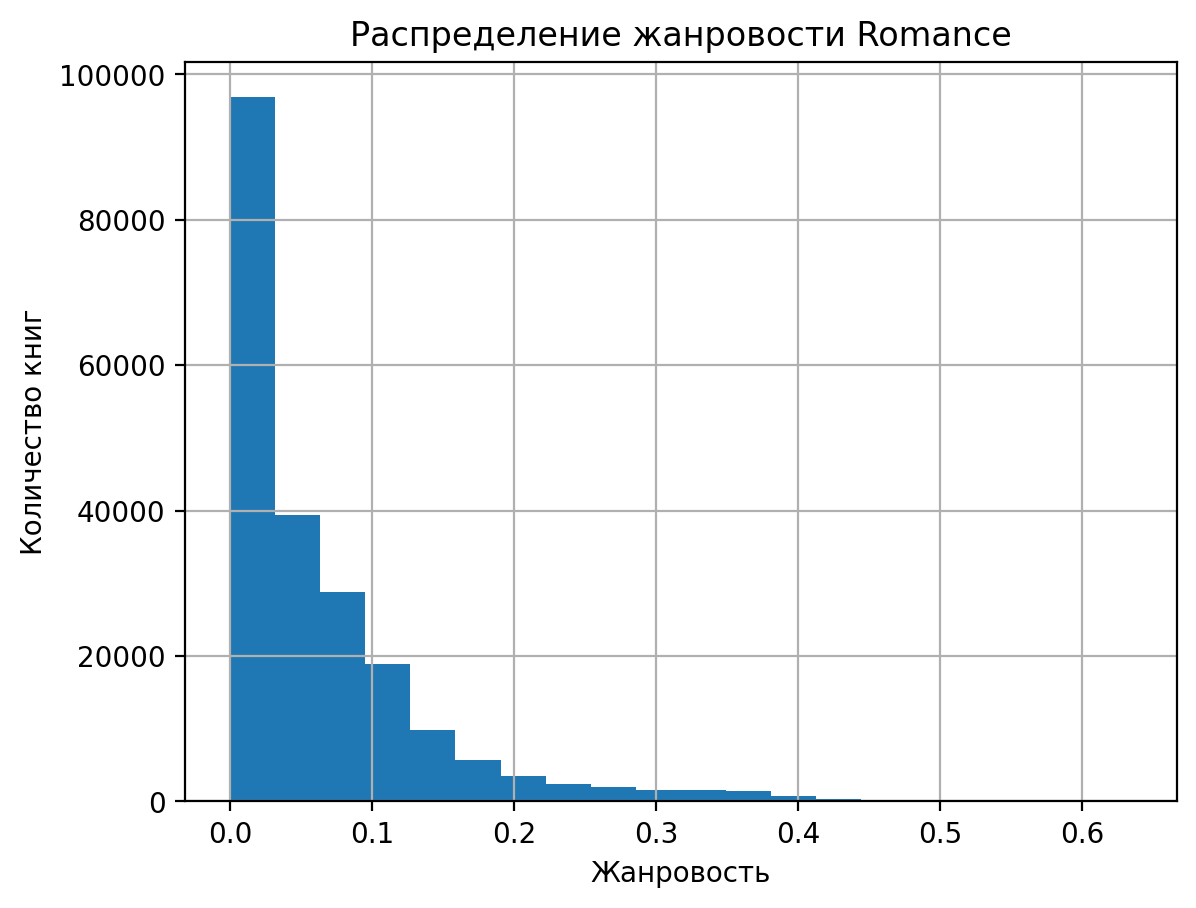

In [80]:
# Находим ID жанра Romance
romance_id = genres[genres['name'] == 'Romance'].index[0]
romance_col = f"genre_{romance_id}"

# Проверяем, что колонка существует
if romance_col in candidates_for_train.columns:
    # Вычисляем медиану
    romance_median = candidates_for_train[romance_col].median()
    
    # Дополнительная статистика
    romance_stats = candidates_for_train[romance_col].describe()
    
    print(f"Медиана жанровости Romance: {romance_median:.2f}")
    print("\nПолная статистика по жанру Romance:")
    print(romance_stats)
    
    # Визуализация
    import matplotlib.pyplot as plt
    candidates_for_train[romance_col].hist(bins=20)
    plt.title("Распределение жанровости Romance")
    plt.xlabel("Жанровость")
    plt.ylabel("Количество книг")
    plt.show()
else:
    print(f"Колонка {romance_col} не найдена в данных. Доступные жанры:")
    print([col for col in candidates_for_train.columns if col.startswith('genre_')])

In [81]:
from catboost import CatBoostClassifier, Pool

# задаём имена колонок признаков и таргета
features = ['als_score', 'cnt_score', 
    'age', 'average_rating', 'reading_years', 'books_read', 
    'rating_avg', 'rating_std', 
    'books_per_year'] + genre_columns
target = 'target'

# создаём Pool
train_data = Pool(
    data=candidates_for_train[features], 
    label=candidates_for_train[target])

# инициализируем модель CatBoostClassifier
cb_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    verbose=100,
    random_seed=0,
)

# тренируем модель
cb_model.fit(train_data)

0:	learn: 0.6484998	total: 239ms	remaining: 3m 58s
100:	learn: 0.4658299	total: 4.33s	remaining: 38.5s
200:	learn: 0.4575030	total: 7.3s	remaining: 29s
300:	learn: 0.4517578	total: 10.3s	remaining: 23.9s
400:	learn: 0.4471332	total: 13.2s	remaining: 19.7s
500:	learn: 0.4429470	total: 16.1s	remaining: 16.1s
600:	learn: 0.4390814	total: 18.8s	remaining: 12.5s
700:	learn: 0.4355643	total: 21.8s	remaining: 9.28s
800:	learn: 0.4321811	total: 24.8s	remaining: 6.16s
900:	learn: 0.4289168	total: 27.6s	remaining: 3.03s
999:	learn: 0.4257913	total: 30.3s	remaining: 0us


In [82]:
# Получаем предсказания для ранжирования
inference_data = Pool(data=candidates_to_rank[features], feature_names=features)
predictions = cb_model.predict_proba(inference_data)

# Добавляем предсказания в датафрейм (берём вероятность класса 1)
candidates_to_rank["cb_score"] = predictions[:, 1]

# Ранжируем рекомендации для каждого пользователя
candidates_to_rank = candidates_to_rank.sort_values(["user_id", "cb_score"], ascending=[True, False])
candidates_to_rank["rank"] = candidates_to_rank.groupby("user_id").cumcount() + 1

# Отбираем топ-100 рекомендаций
max_recommendations_per_user = 100
final_recommendations = candidates_to_rank.query("rank <= @max_recommendations_per_user")

# Проверяем результат
print(f"Всего рекомендаций: {len(final_recommendations)}")
print(f"Уникальных пользователей: {final_recommendations['user_id'].nunique()}")
print(f"Рекомендаций на пользователя: {final_recommendations.groupby('user_id').size().mean():.1f}")


Всего рекомендаций: 7511500
Уникальных пользователей: 75115
Рекомендаций на пользователя: 100.0


In [86]:
# Сохраняем рекомендации в parquet-файл
final_recommendations.to_parquet("final_recommendations_feat.parquet", index=False)

In [87]:
# Подготовка данных для расчета метрик
events_inference = pd.concat([events_train, events_labels])
events_inference = events_inference[events_inference["user_id"].isin(events_test_2["user_id"].drop_duplicates())]

# Расчет метрик для топ-5 рекомендаций
cb_events_recs_for_binary_metrics_5 = process_events_recs_for_binary_metrics(
    events_inference,
    events_test_2,  # Тестовая выборка
    final_recommendations.rename(columns={"cb_score": "score"}),  # Переименовываем для совместимости
    top_k=5  # Анализируем топ-5 рекомендаций
)

# Вычисление метрик
cb_precision_5, cb_recall_5 = compute_cls_metrics(cb_events_recs_for_binary_metrics_5)

print(f"Precision@5: {cb_precision_5:.3f}, Recall@5: {cb_recall_5:.3f}")

Common users: 75115
Precision@5: 0.011, Recall@5: 0.030


In [88]:
# Получаем важность признаков и создаем DataFrame
feature_importance = pd.DataFrame(
    cb_model.get_feature_importance(),
    index=features,
    columns=["importance"]
)

# Сортируем по убыванию важности
feature_importance = feature_importance.sort_values("importance", ascending=False)

# Выводим результаты
print("Важность признаков (по убыванию):")
print(feature_importance)

Важность признаков (по убыванию):
                importance
als_score        25.426412
age              19.493990
average_rating   15.227336
books_read        6.578733
reading_years     3.515584
cnt_score         3.343729
genre_1           2.727501
genre_25          2.726073
genre_18          2.660354
genre_others      2.626251
genre_34          2.295918
books_per_year    2.093657
genre_33          1.602927
genre_38          1.600177
rating_avg        1.569886
genre_16          1.467684
genre_24          1.429592
genre_20          1.421378
genre_5           1.197066
rating_std        0.995754
